# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
import json
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets

my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API Request URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_response_data = requests.get(btc_url).json()

# btc_response_data
my_btc_value = btc_response_data['data']['1']['quotes']['CAD']['price']

# Fetch current ETH price
eth_response_data = requests.get(eth_url).json()

# Compute current value of my crypto
my_eth_value = eth_response_data['data']['1027']['quotes']['CAD']['price']

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value*my_btc:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value*my_eth:0.2f}")


The current value of your 1.2 BTC is $32426.16
The current value of your 5.3 ETH is $7496.94


In [6]:
my_btc_total = (my_btc_value*my_btc)
my_eth_total = (my_eth_value*my_eth)


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Create the Alpaca API object
alpaca = tradeapi.REST(alpaca_api_key,alpaca_secret_key,api_version="v2")


In [9]:
# Format current date as ISO format
today = pd.Timestamp("2022-06-10", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

agg_close_price_raw = alpaca.get_bars("AGG", timeframe, start = today, end = today).df
spy_close_price_raw = alpaca.get_bars("SPY", timeframe, start = today, end = today).df

agg_close_price_raw['close']


timestamp
2022-06-10 04:00:00+00:00    101.26
Name: close, dtype: float64

In [10]:
# Reorganize the DataFrame & seperate tickerdata

my_shares = alpaca.get_bars(tickers, timeframe, start = today, end = today).df

# Format start and end dates as ISO format for one year period
start = pd.Timestamp("2021-06-1", tz="America/New_York").isoformat()
end = pd.Timestamp("2022-06-10", tz="America/New_York").isoformat()

# Preview DataFrame
my_shares.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2022-06-10 04:00:00+00:00,101.67,101.7200,101.03,101.26,7814825,29812,101.293852,AGG
2022-06-10 04:00:00+00:00,394.88,395.7777,389.75,389.80,132466355,910453,392.887543,SPY


In [11]:

my_share_close = my_shares.loc[:, ['symbol', 'close']]

my_share_close.head()


,symbol,close
timestamp,,
2022-06-10 04:00:00+00:00,AGG,101.26
2022-06-10 04:00:00+00:00,SPY,389.80


In [12]:
# Get current closing prices for SPY and AGG
# Pick AGG and SPY close prices
agg_close = my_share_close.iloc[0]['close']
spy_close = my_share_close.iloc[1]['close']
test_close = my_shares.groupby('symbol') == 'AGG','close'


In [13]:
print(agg_close)


101.26


In [14]:
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close:0.2f}")
print(f"Current SPY closing price: ${spy_close:0.2f}")


Current AGG closing price: $101.26
Current SPY closing price: $389.80


In [15]:
# Compute the current value of shares

my_spy_value = (my_spy*spy_close)
my_agg_value = (my_agg*agg_close)

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19490.00
The current value of your 200 AGG shares is $20252.00


### Savings Health Analysis

In [16]:
# Set monthly household income :Note Monthly household income $12,000
monthly_household_income = 12000
# Consolidate financial assets data

crypto = (my_btc_total+ my_eth_total)
shares = (my_spy_value+my_agg_value)

print(crypto,shares)

39923.100099999996 39742.0


In [17]:
# Create savings DataFrame

savings = {'amount': [crypto , shares]}

savings_df = pd.DataFrame(savings, columns = ['amount'], index = ['crypto', 'shares'])

savings_df['amount'].round(decimals = 1) 
# Display savings DataFrame
print (savings_df)


            amount
crypto  39923.1001
shares  39742.0000


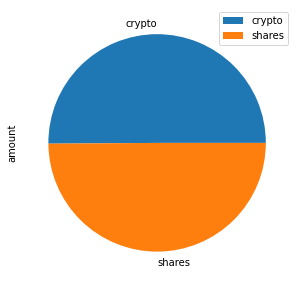

In [18]:
# Plot savings pie chart

savings_df_plot = savings_df.plot.pie(y='amount',figsize = (5,5))


In [19]:
# Set ideal emergency fund
emergency_fund = monthly_household_income * 3

# Calculate total amount of savings

total_household_savings = savings_df['amount'].sum()
# Validate saving health

print(f'Your total household savings are $',total_household_savings,': A healthy emergency fund is $',emergency_fund)

Your total household savings are $ 79665.1001 : A healthy emergency fund is $ 36000


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [20]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_mc = pd.Timestamp('2017-05-01', tz='America/New_York').isoformat()
end_mc = pd.Timestamp('2022-05-01', tz='America/New_York').isoformat()

In [21]:
# Get 5 years' worth of historical data for SPY and AGG
historic_5year_df = alpaca.get_bars(
    tickers, 
    timeframe,
    start = start_mc,
    end = end_mc,
).df 


historic_5year_df.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,108.86,108.9599,108.620,108.73,2510027,11008,108.743679,AGG
2017-05-02 04:00:00+00:00,108.68,108.9400,108.679,108.88,2841518,9263,108.831870,AGG
2017-05-03 04:00:00+00:00,108.97,108.9900,108.770,108.77,1923403,10987,108.902870,AGG
2017-05-04 04:00:00+00:00,108.55,108.7000,108.550,108.68,1897912,7501,108.629678,AGG
2017-05-05 04:00:00+00:00,108.72,108.7400,108.570,108.70,1421843,7385,108.675918,AGG


In [22]:
# Reorganize the DataFrame
AGG = historic_5year_df[historic_5year_df['symbol']=='AGG'].drop('symbol', axis=1)
SPY = historic_5year_df[historic_5year_df['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
historic_5year_df = pd.concat([AGG, SPY], axis=1, keys=["AGG", "SPY"])

# Display sample data
historic_5year_df.head()


AGG                                      \
                             open      high      low   close   volume   
timestamp                                                               
2017-05-01 04:00:00+00:00  108.86  108.9599  108.620  108.73  2510027   
2017-05-02 04:00:00+00:00  108.68  108.9400  108.679  108.88  2841518   
2017-05-03 04:00:00+00:00  108.97  108.9900  108.770  108.77  1923403   
2017-05-04 04:00:00+00:00  108.55  108.7000  108.550  108.68  1897912   
2017-05-05 04:00:00+00:00  108.72  108.7400  108.570  108.70  1421843   

                                                      SPY                     \
                          trade_count        vwap    open      high      low   
timestamp                                                                      
2017-05-01 04:00:00+00:00       11008  108.743679  238.66  239.1700  238.195   
2017-05-02 04:00:00+00:00        9263  108.831870  238.82  238.9800  238.300   
2017-05-03 04:00:00+00:00       10987  108.902870  238.29  238.8775  237.700   
2017-05-04 04:00:00+00:00        7501  108.629678  238.81  238.9225  237.780   
2017-05-05 04:00:00+00:00        7385  108.675918  239.16  239.7200  238.680   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2017-05-01 04:00:00+00:00  238.68  66882521      180740  238.682276  
2017-05-02 04:00:00+00:00  238.77  57375732      176648  238.630973  
2017-05-03 04:00:00+00:00  238.48  73137731      223568  238.418100  
2017-05-04 04:00:00+00:00  238.76  61462732      208872  238.541805  
2017-05-05 04:00:00+00:00  239.70  62001269      204885  239.253410

In [23]:
# Separate ticker data
# Display sample data

In [24]:
# Concatenate the ticker DataFrames

In [25]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns

mc_30_yr_std_60_40 = MCSimulation(
    portfolio_data = historic_5year_df,
    weights = [.4,.6],
    num_simulation = 500,
    num_trading_days = 252*30)

In [26]:
# Printing the simulation input data
mc_30_yr_std_60_40.portfolio_data.head()


AGG                                      \
                             open      high      low   close   volume   
timestamp                                                               
2017-05-01 04:00:00+00:00  108.86  108.9599  108.620  108.73  2510027   
2017-05-02 04:00:00+00:00  108.68  108.9400  108.679  108.88  2841518   
2017-05-03 04:00:00+00:00  108.97  108.9900  108.770  108.77  1923403   
2017-05-04 04:00:00+00:00  108.55  108.7000  108.550  108.68  1897912   
2017-05-05 04:00:00+00:00  108.72  108.7400  108.570  108.70  1421843   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-05-01 04:00:00+00:00       11008  108.743679          NaN  238.66   
2017-05-02 04:00:00+00:00        9263  108.831870     0.001380  238.82   
2017-05-03 04:00:00+00:00       10987  108.902870    -0.001010  238.29   
2017-05-04 04:00:00+00:00        7501  108.629678    -0.000827  238.81   
2017-05-05 04:00:00+00:00        7385  108.675918     0.000184  239.16   

                                                                            \
                               high      low   close    volume trade_count   
timestamp                                                                    
2017-05-01 04:00:00+00:00  239.1700  238.195  238.68  66882521      180740   
2017-05-02 04:00:00+00:00  238.9800  238.300  238.77  57375732      176648   
2017-05-03 04:00:00+00:00  238.8775  237.700  238.48  73137731      223568   
2017-05-04 04:00:00+00:00  238.9225  237.780  238.76  61462732      208872   
2017-05-05 04:00:00+00:00  239.7200  238.680  239.70  62001269      204885   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-05-01 04:00:00+00:00  238.682276          NaN  
2017-05-02 04:00:00+00:00  238.630973     0.000377  
2017-05-03 04:00:00+00:00  238.418100    -0.001215  
2017-05-04 04:00:00+00:00  238.541805     0.001174  
2017-05-05 04:00:00+00:00  239.253410     0.003937

In [27]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
mc_30_yr_std_60_40.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\users\garry\desktop\Monash Classwork\homework challenges\mod 5\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000019,0.988808,1.002958,1.004330,1.010843,0.995158,1.000375,1.009795,0.991569,1.007879,...,0.989054,0.989125,1.006002,0.996159,1.005964,0.999353,0.985175,1.002788,0.991328,0.993932
2,0.999026,0.990697,0.994745,1.001117,1.015601,0.981209,1.002653,1.007695,0.983407,1.007465,...,0.987148,0.997907,0.998019,0.995233,1.002063,1.000832,0.975534,1.005777,0.988243,1.004404
3,1.002915,0.995678,0.991138,1.000131,1.020369,0.974189,1.005007,1.007765,0.983209,1.005009,...,0.987864,0.983057,1.009029,0.995959,1.009966,0.995229,0.975219,0.999106,0.989337,1.003836
4,1.013870,0.995083,0.989846,1.000094,1.025048,0.980249,1.005650,1.016644,0.992770,1.000732,...,1.004772,0.977602,1.008188,0.990527,1.004431,1.001581,0.976397,1.005300,0.991749,0.999442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,8.176260,2.363886,15.804256,19.212067,9.722988,14.360877,4.710354,7.154059,2.717426,22.924078,...,9.172184,13.523528,2.045861,6.741534,3.914812,5.813280,20.413017,8.613554,5.126178,5.063916
7557,8.142974,2.380806,15.862704,19.323348,9.754616,14.315525,4.700985,7.107879,2.726232,22.766637,...,9.124184,13.421577,2.011790,6.739509,3.893604,5.793287,20.496626,8.457579,5.145484,5.067705
7558,8.067006,2.409388,15.608086,19.213470,9.781544,14.083446,4.671923,7.133362,2.707156,22.813575,...,9.030705,13.443907,2.033503,6.638430,3.880301,5.736396,20.447694,8.411927,5.208620,5.052769
7559,8.017580,2.383482,15.664757,19.082718,9.831459,14.242941,4.692558,7.150732,2.737309,22.580306,...,9.048912,13.519611,2.051932,6.608616,3.901007,5.777874,20.475178,8.423179,5.239780,5.022321


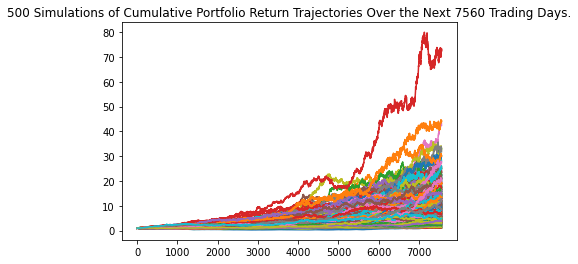

In [28]:
# Plot simulation outcomes
mc_30_line_plot = mc_30_yr_std_60_40.plot_simulation()


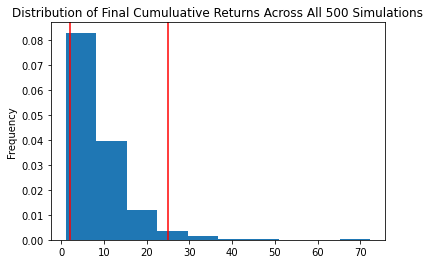

In [29]:
# Plot probability distribution and confidence intervals
mc_30_distrib_plot = mc_30_yr_std_60_40.plot_distribution()


### Retirement Analysis

In [30]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_30_summary_stats = mc_30_yr_std_60_40.summarize_cumulative_return()

# Print summary statistics
print(mc_30_summary_stats)


count           500.000000
mean              8.922527
std               6.774123
min               1.057277
25%               4.608204
50%               7.116902
75%              10.883141
max              72.299525
95% CI Lower      1.979964
95% CI Upper     24.958589
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [31]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
std_60_40_ci_lower = round(mc_30_summary_stats[8]*initial_investment,2)
std_60_40_ci_upper = round(mc_30_summary_stats[9]*initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${std_60_40_ci_lower} and ${std_60_40_ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $39599.29 and $499171.78


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [32]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
std_60_40_ci_lower = round(mc_30_summary_stats[8]*initial_investment,2)
std_60_40_ci_upper = round(mc_30_summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${std_60_40_ci_lower} and ${std_60_40_ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $59398.93 and $748757.68


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [33]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_5_yr_high_85_15 = MCSimulation(
    portfolio_data = historic_5year_df,
    weights = [.15,.85],
    num_simulation = 500,
    num_trading_days = 252*5)


In [34]:
mc_5_yr_std_60_40 = MCSimulation(
    portfolio_data = historic_5year_df,
    weights = [.4,.6],
    num_simulation = 500,
    num_trading_days = 252*5)

In [35]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc_5_yr_high_85_15.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\users\garry\desktop\Monash Classwork\homework challenges\mod 5\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.012690,1.008175,1.007075,1.017144,1.000778,1.008190,0.990142,1.004171,0.990626,0.985672,...,1.003582,0.978283,1.013374,1.020726,1.008555,1.006646,1.003417,0.972340,1.010118,1.006240
2,1.027774,1.005868,1.017830,1.027098,1.000780,1.014132,0.990173,1.001833,0.991084,0.971450,...,0.999237,0.970132,1.011591,1.019448,1.014540,1.019114,0.985665,0.967983,1.014711,1.006416
3,1.037160,0.999179,1.020782,1.036320,0.986524,1.008285,0.982596,1.014499,0.991626,0.988410,...,0.994591,0.976880,1.004035,1.008454,1.001230,1.014629,0.991320,0.969250,1.001071,1.033079
4,1.038258,1.001373,1.019780,1.036422,0.993712,1.021244,0.986691,1.030096,0.993651,0.982568,...,0.994220,0.957815,0.998982,1.009055,1.000188,1.019450,0.986831,0.969742,1.004326,1.036373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.755824,1.637377,2.129636,2.867221,2.021986,3.364989,1.843919,0.552298,0.899284,0.954675,...,1.706667,1.775414,0.870567,1.288792,2.191072,1.922100,2.274095,1.516908,0.917556,2.876668
1257,1.703003,1.650075,2.132171,2.879944,1.985678,3.387707,1.865494,0.545222,0.894557,0.943752,...,1.703963,1.780627,0.866978,1.292754,2.190650,1.919547,2.309252,1.530373,0.918173,2.921026
1258,1.679239,1.661372,2.093073,2.880060,1.968122,3.415427,1.890512,0.532998,0.887823,0.944984,...,1.698987,1.775429,0.874719,1.284820,2.213790,1.925124,2.313370,1.548860,0.914034,2.869436
1259,1.662607,1.655671,2.054715,2.875174,2.005577,3.414262,1.844331,0.542835,0.879767,0.940847,...,1.729501,1.783181,0.875145,1.265031,2.177660,1.940647,2.294869,1.503457,0.930041,2.892608


In [36]:
mc_5_yr_std_60_40.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\users\garry\desktop\Monash Classwork\homework challenges\mod 5\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.988276,1.009853,0.986816,1.002962,0.996814,1.002329,0.998593,0.993100,0.996911,0.998325,...,1.003721,1.002323,1.001236,1.000984,0.999093,1.021917,1.001036,0.997013,1.008587,0.997411
2,0.989208,0.999850,0.989442,1.002369,1.001472,1.001083,0.987742,0.985692,0.994924,1.007762,...,0.998123,0.997505,0.993365,1.006651,1.005446,1.015970,0.993735,1.002580,1.017445,0.996680
3,1.001557,0.994233,0.986075,1.005957,0.995115,1.011117,0.995238,0.971404,1.000070,1.006648,...,0.996590,1.006893,0.997252,1.000524,1.014778,1.005705,0.989105,1.017175,1.015229,1.009345
4,0.997761,0.992732,0.990973,1.001387,1.011939,1.007049,1.003735,0.977128,0.999907,1.013081,...,0.990434,0.990516,0.994088,0.998842,1.015442,0.991991,0.986917,1.008803,1.024124,1.011856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.871236,1.267939,1.631985,1.735885,1.080719,1.139461,1.194636,1.154639,0.863387,2.203498,...,1.308442,1.260371,1.165700,2.397941,1.832303,1.999069,1.533869,1.229333,1.183456,1.618061
1257,1.869414,1.291982,1.643404,1.728907,1.082841,1.125163,1.188131,1.161853,0.861990,2.216264,...,1.308255,1.249034,1.155930,2.405517,1.820335,1.994808,1.532795,1.225687,1.188128,1.600461
1258,1.880483,1.308866,1.628347,1.721445,1.080947,1.133361,1.193268,1.167712,0.874701,2.209572,...,1.308662,1.245985,1.137194,2.384835,1.829073,2.005512,1.532308,1.217092,1.201127,1.592022
1259,1.873714,1.313506,1.630997,1.725490,1.079622,1.141638,1.200101,1.167842,0.882670,2.222816,...,1.313074,1.251826,1.141062,2.388226,1.823450,1.997817,1.529791,1.201414,1.190444,1.571157


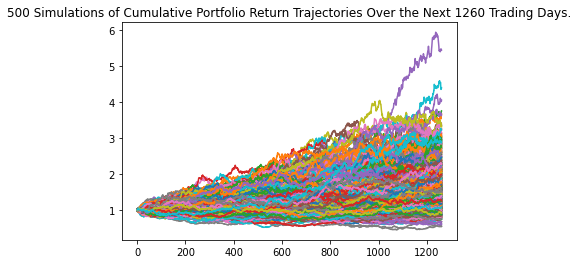

In [37]:
# Plot simulation outcomes
mc_5_line_plot = mc_5_yr_high_85_15.plot_simulation()

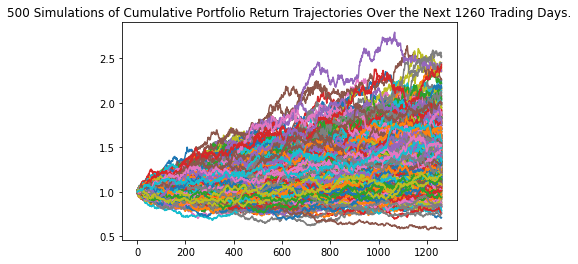

In [38]:
mc_5_std_line_plot = mc_5_yr_std_60_40.plot_simulation()

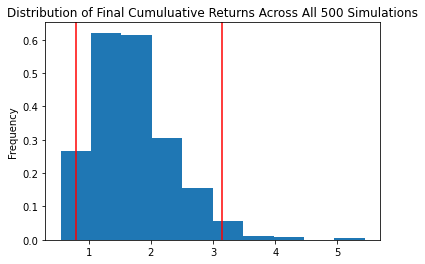

In [39]:
# Plot probability distribution and confidence intervals
mc_5_distrib_plot = mc_5_yr_high_85_15.plot_distribution()

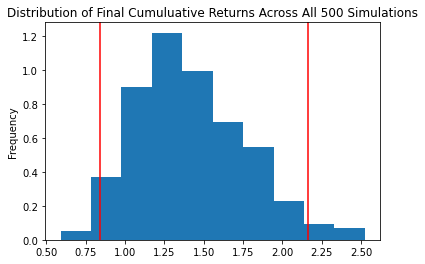

In [40]:
mc_5_std_distrib_plot = mc_5_yr_std_60_40.plot_distribution()

In [41]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_5_summary_stats = mc_5_yr_high_85_15.summarize_cumulative_return()

# Print summary statistics
print(mc_5_summary_stats)

count           500.000000
mean              1.712648
std               0.653005
min               0.545763
25%               1.241280
50%               1.623189
75%               2.056703
max               5.441071
95% CI Lower      0.788693
95% CI Upper      3.136985
Name: 1260, dtype: float64


In [42]:
mc_5_std_summary_stats = mc_5_yr_std_60_40.summarize_cumulative_return()

print(mc_5_std_summary_stats)

count           500.000000
mean              1.416784
std               0.345890
min               0.590413
25%               1.160274
50%               1.370415
75%               1.636720
max               2.523416
95% CI Lower      0.843139
95% CI Upper      2.162356
Name: 1260, dtype: float64


In [43]:
# Set initial investment
initial_investment_5_yr_high = 20000 

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
high_85_15_ci_lower = round(mc_5_summary_stats[8]*initial_investment_5_yr_high,2)
high_85_15_ci_upper = round(mc_5_summary_stats[9]*initial_investment_5_yr_high,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_5_yr_high} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${high_85_15_ci_lower} and ${high_85_15_ci_upper}")


There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $15773.85 and $62739.7


In [44]:
initial_investment_5_yr_high = 20000 * 1.5

high_85_15_ci_lower = round(mc_5_summary_stats[8]*initial_investment_5_yr_high,2)
high_85_15_ci_upper = round(mc_5_summary_stats[9]*initial_investment_5_yr_high,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_5_yr_high} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${high_85_15_ci_lower} and ${high_85_15_ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 5 years will end within in the range of $23660.78 and $94109.56


In [45]:
initial_investment_5_yr_std = 20000 * 3

short_60_40_ci_lower = round(mc_5_std_summary_stats[8]*initial_investment_5_yr_std,2)
short_60_40_ci_upper = round(mc_5_std_summary_stats[9]*initial_investment_5_yr_std,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_5_yr_std} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${short_60_40_ci_lower} and ${short_60_40_ci_upper}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $50588.32 and $129741.37


### Ten Years Retirement Option

In [46]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
mc_10_yr_mod_80_20 = MCSimulation(
    portfolio_data = historic_5year_df,
    weights = [.2,.8],
    num_simulation = 500,
    num_trading_days = 252*10)


In [47]:
mc_10_yr_std_60_40 = MCSimulation(
    portfolio_data = historic_5year_df,
    weights = [.4,.6],
    num_simulation = 500,
    num_trading_days = 252*10)

In [48]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc_10_yr_mod_80_20.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\users\garry\desktop\Monash Classwork\homework challenges\mod 5\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006535,1.008169,1.003329,1.002380,0.976425,0.988828,1.008200,0.996350,1.004100,1.005770,...,1.024978,1.008662,1.019394,1.013274,0.991734,0.994509,0.985320,1.000376,0.990577,1.007136
2,1.003644,1.013492,1.030885,1.004396,0.988697,0.975655,1.006918,0.989353,1.000359,1.018764,...,1.038471,1.010502,1.012693,1.018592,0.980170,0.997045,0.987924,1.003538,0.967940,1.016355
3,1.002626,1.018268,1.042725,1.016172,1.007959,0.986657,1.020702,0.988907,1.011319,1.008273,...,1.022017,1.005427,1.017789,0.997901,0.971762,1.014798,0.988662,1.001368,0.964094,1.022451
4,1.001133,1.018545,1.030822,1.019640,1.001808,0.984067,1.021969,0.996776,1.023067,1.010393,...,1.035634,0.998970,1.026980,0.996112,0.972804,1.020342,0.975373,0.992564,0.975469,1.016993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,4.284823,1.625418,2.255363,2.586417,2.235687,4.035190,2.916666,2.171111,1.398162,1.466301,...,2.347410,1.629834,0.939254,5.233421,2.613000,3.429469,1.091152,1.909455,1.737173,2.039320
2517,4.283237,1.618864,2.218915,2.595962,2.237443,4.009564,2.891514,2.177732,1.410215,1.474577,...,2.369305,1.598854,0.932629,5.333561,2.623521,3.422385,1.093319,1.926636,1.751467,2.041497
2518,4.261346,1.640638,2.181504,2.578953,2.252365,3.964582,2.883966,2.223041,1.433111,1.508422,...,2.376014,1.607821,0.923720,5.271505,2.634036,3.435061,1.080113,1.960340,1.740716,2.016377
2519,4.226171,1.654929,2.186960,2.640447,2.254807,3.874788,2.895269,2.213059,1.435065,1.492996,...,2.367801,1.611803,0.928117,5.295799,2.643530,3.466715,1.069253,1.976746,1.749049,2.021736


In [49]:
mc_10_yr_std_60_40.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\users\garry\desktop\Monash Classwork\homework challenges\mod 5\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002985,1.000505,1.001911,1.006605,1.003471,1.008568,0.995001,1.007286,1.004471,0.989457,...,0.999936,1.002268,0.999893,0.990190,0.990697,1.001642,0.998037,0.989852,0.986420,1.004183
2,1.001198,1.007217,1.006358,1.005646,1.007436,0.997574,1.001791,1.003803,0.996059,1.000607,...,0.995268,0.992998,1.012885,0.978886,0.988622,1.004057,1.006557,0.983598,0.990422,1.000783
3,0.992746,1.003337,1.013357,0.986399,1.003298,1.001193,0.998923,1.003342,0.995821,1.007562,...,1.003669,0.986392,1.013479,0.980514,0.980728,1.011674,0.985389,0.975102,0.999917,1.007374
4,1.000809,1.010711,1.004944,0.985088,0.995827,1.006133,0.991710,1.000035,0.982399,1.012325,...,0.996246,0.994760,1.012754,0.983744,0.971675,1.016735,0.990492,0.971837,1.006292,1.010662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.922620,1.797218,1.686295,1.906233,1.532446,1.632537,1.824598,1.682148,2.447833,2.117102,...,1.206938,1.131991,2.180328,2.628665,1.398649,3.090515,5.250619,2.195178,1.577728,2.508313
2517,1.928839,1.798812,1.683775,1.927529,1.552136,1.648065,1.826162,1.679798,2.474570,2.142477,...,1.195925,1.140626,2.156273,2.639629,1.390245,3.098303,5.195972,2.188071,1.589844,2.476667
2518,1.920280,1.771764,1.659196,1.920508,1.542819,1.628474,1.823527,1.684501,2.480009,2.148040,...,1.200482,1.143481,2.161554,2.651314,1.385815,3.107766,5.231642,2.173686,1.599144,2.479270
2519,1.921278,1.753487,1.651670,1.928447,1.548551,1.621415,1.812128,1.686681,2.454390,2.165083,...,1.196102,1.133386,2.182880,2.629221,1.388982,3.105285,5.189143,2.172140,1.586864,2.499402


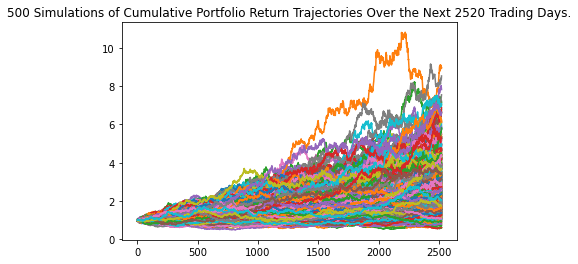

In [50]:
# Plot simulation outcomes
mc_10_line_plot = mc_10_yr_mod_80_20.plot_simulation()

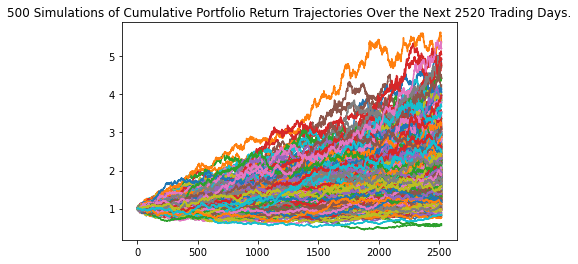

In [51]:
mc_10_std_line_plot = mc_10_yr_std_60_40.plot_simulation()

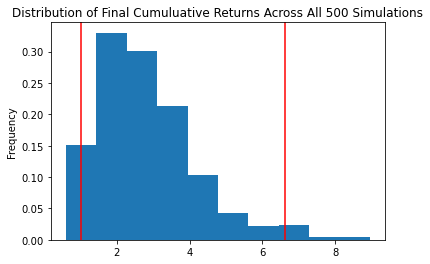

In [52]:
# Plot probability distribution and confidence intervals
mc_10_distrib_plot = mc_10_yr_mod_80_20.plot_distribution()

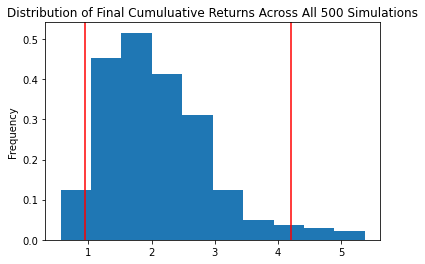

In [53]:
mc_10_std_distrib_plot = mc_10_yr_std_60_40.plot_distribution()

In [54]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_10_summary_stats = mc_10_yr_mod_80_20.summarize_cumulative_return()

# Print summary statistics
print(mc_10_summary_stats)

count           500.000000
mean              2.816997
std               1.381112
min               0.595359
25%               1.807320
50%               2.528429
75%               3.499497
max               8.958212
95% CI Lower      1.000645
95% CI Upper      6.610991
Name: 2520, dtype: float64


In [55]:
mc_10_std_summary_stats = mc_10_yr_std_60_40.summarize_cumulative_return()

print(mc_10_std_summary_stats)

count           500.000000
mean              2.090361
std               0.838313
min               0.561903
25%               1.476041
50%               1.941778
75%               2.540081
max               5.369745
95% CI Lower      0.943844
95% CI Upper      4.196574
Name: 2520, dtype: float64


In [56]:
# Set initial investment
initial_investment_10_yr_mod = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
mod_80_20_ci_lower = round(mc_10_summary_stats[8]*initial_investment_10_yr_mod,2)
mod_80_20_ci_upper = round(mc_10_summary_stats[9]*initial_investment_10_yr_mod,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10_yr_mod} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${mod_80_20_ci_lower} and ${mod_80_20_ci_upper}")


There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $20012.91 and $132219.82


In [57]:
initial_investment_10_yr_mod = 20000 * 1.5

mod_80_20_ci_lower = round(mc_10_summary_stats[8]*initial_investment_10_yr_mod,2)
mod_80_20_ci_upper = round(mc_10_summary_stats[9]*initial_investment_10_yr_mod,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10_yr_mod} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${mod_80_20_ci_lower} and ${mod_80_20_ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 10 years will end within in the range of $30019.36 and $198329.73


In [58]:
initial_investment_10_yr_std = 20000 * 3

std_60_40_ci_lower = round(mc_10_std_summary_stats[8]*initial_investment_10_yr_std,2)
std_60_40_ci_upper = round(mc_10_std_summary_stats[9]*initial_investment_10_yr_std,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10_yr_std} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${std_60_40_ci_lower} and ${std_60_40_ci_upper}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $56630.65 and $251794.45
